In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

(train, test), info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info= True
)

info

2024-05-06 11:54:21.826261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 11:54:21.826353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 11:54:21.997867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteAFAZ23',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

(333, 500, 3)
(212, 320, 3)
(240, 320, 3)
(240, 320, 3)
(317, 500, 3)
(212, 320, 3)
(240, 240, 3)
(333, 500, 3)


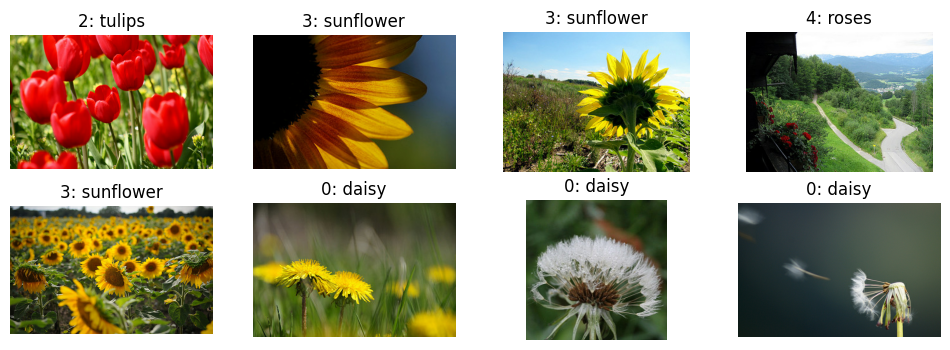

In [2]:
label_names= ["daisy", "danelion", "tulips", "sunflower", "roses"]
fig, axes= plt.subplots(2, 4, figsize= (12, 4))

for ax, image in zip(axes.flatten(), train.take(8)):
    print(image[0].shape)
    ax.imshow(image[0])
    label= image[1]
    ax.set_title(f"{label}: {label_names[label]}")
    ax.axis("off")

## preprocess images

In [3]:
def preprocess_images(image, label, shape= (120, 120)):
    image = tf.image.resize(image, shape) / 255

    return image, label


input_shape = 120, 120, 3
batch_size = 32

# picks out batches
train_batch = (
    train.shuffle(buffer_size=600).map(preprocess_images).batch(batch_size).prefetch(1)
)
test_batch = test.map(preprocess_images).batch(batch_size).prefetch(1)

test_batch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [4]:
from tensorflow.keras.applications import Xception

feature_extractor= Xception(weights= "imagenet", include_top= False, input_shape= input_shape)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
feature_extractor.layers[:5]

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <BatchNormalization name=block1_conv1_bn, built=True>,
 <Activation name=block1_conv1_act, built=True>,
 <Conv2D name=block1_conv2, built=True>]

In [6]:
feature_extractor.layers[1].trainable

True

In [7]:
print([layer.trainable for layer in feature_extractor.layers])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


## Buld MLP model and freeze feature extractor

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

model = Sequential(
    [
        feature_extractor,
        GlobalAveragePooling2D(),
        Dropout(.5),
        Dense(256, activation= "relu", kernel_initializer= "he_normal"),
        Dropout(0.5), 
        Dense(5, activation= "softmax")
    ]
)

for layer in feature_extractor.layers:
    layer.trainable= False

model.compile(optimizer= "adam", loss= "sparse_categorical_crossentropy")

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:
model.fit(train_batch, epochs= 20, validation_data= test_batch)

Epoch 1/20
 3/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 2.0886

I0000 00:00:1714996495.208359     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714996495.248189     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 1.2321

W0000 00:00:1714996506.801503     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714996509.963775     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - loss: 1.2293 - val_loss: 0.5825
Epoch 2/20


W0000 00:00:1714996516.880576     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 0.6661 - val_loss: 0.5287
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.5469 - val_loss: 0.4898
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.5189 - val_loss: 0.4941
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.4959 - val_loss: 0.4812
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.4793 - val_loss: 0.4749
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.3976 - val_loss: 0.4445
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.3762 - val_loss: 0.4524
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.3813 - val_loss: 0.4547
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.3520 - val_loss: 0.4334
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.3722 - val_loss: 0.4457
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.3305 - val_loss: 0.4409
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.3104 - val

In [11]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,val_loss
0,0.967907,0.582459
1,0.655371,0.528707
2,0.575926,0.489790
3,0.510216,0.494052
4,0.489246,0.481241
5,0.451802,0.474926
6,0.398154,0.444523
7,0.406854,0.452355
8,0.392259,0.454695
9,0.368456,0.433405


KeyError: "None of [Index(['acc', 'val_acc'], dtype='object')] are in the [columns]"

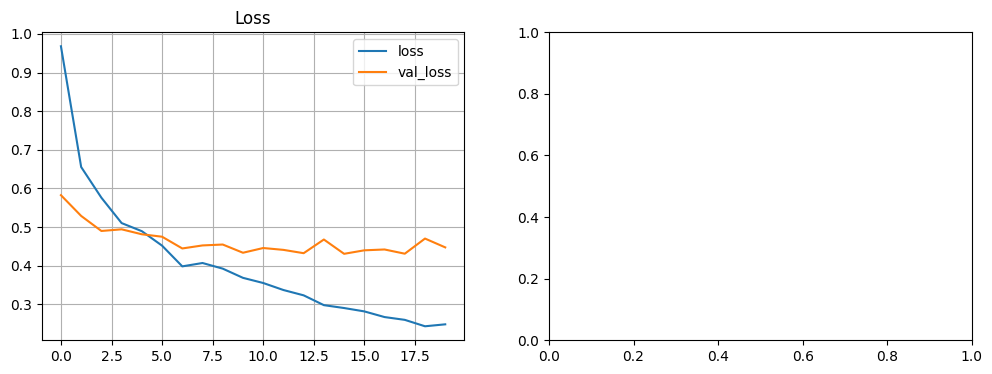

In [12]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

# harder to overfit
plot_metrics(metrics)